In [140]:
import pandas as pd
import numpy as np
import time
import spacy
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data 
import torchtext
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#### Loading Dataset - Preprocessing on the Tweets

In [123]:
datas_dir = r'/content/drive/My Drive/Courses/DeepLearning/HW03/Q01/Datas/train.csv'
destination_folder = '/content/drive/My Drive/Courses/DeepLearning/HW03/Q01/Datas'

In [124]:
df = pd.read_csv(datas_dir, engine="python", header=None)
df.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [125]:
df[0]=df[0].replace(to_replace=4,value=1)
df[0].value_counts()

1    800000
0    800000
Name: 0, dtype: int64

In [126]:
df.sample(200000).to_csv("sentiment140-small.csv", header=None, index=None)

In [127]:
TEXT = torchtext.legacy.data.Field(tokenize='spacy', lower=True, include_lengths= True)
LABEL = torchtext.legacy.data.LabelField(dtype=torch.float)

fields = [('label', LABEL), ('id',None),('date',None),('query',None),
      ('name',None), ('text', TEXT),('category',None)]

dataset = torchtext.legacy.data.TabularDataset(
        path="sentiment140-small.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 160000
Number of test data: 20000
Number of validation data: 20000


In [128]:
# An example from the training set
print(vars(train_data.examples[0]))

{'label': '1', 'text': ['@sestegall', 'passion', 'can', 'be', 'a', 'good', 'thing', '.']}


#### Bulding Vocabulary

In [129]:
MAX_VOCAB_SIZE = 50000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

TEXT.vocab.freqs.most_common(10)

[('i', 99830),
 ('!', 90869),
 ('.', 80553),
 (' ', 58913),
 ('to', 56286),
 ('the', 52462),
 (',', 48108),
 ('a', 38141),
 ('my', 31938),
 ('and', 30251)]

In [130]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

#### Model - LSTM

In [161]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                                                  bidirectional=bidirectional,
                                                  dropout=dropout)

        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text)) 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)


        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))


        return self.predictor(hidden)

In [162]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_1D = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

BIDIRECTIONAL = True
model_2D = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [163]:
pretrained_embeddings = TEXT.vocab.vectors
model_1D.embedding.weight.data.copy_(pretrained_embeddings)
model_2D.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.8522,  0.2270, -0.1693,  ...,  1.1727, -0.8560,  0.9369],
        [ 1.3951,  0.2292,  1.3346,  ...,  2.1832, -0.2196, -1.5070],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 1.4828, -1.8667, -0.7529,  ..., -1.1433,  0.2781,  1.4872],
        [ 0.5523,  0.6045, -1.1275,  ...,  0.1390, -1.8502, -1.0860],
        [ 0.6305,  0.3256,  2.3938,  ..., -0.2270,  0.0838,  1.0589]])

In [164]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_1D.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_1D.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


model_2D.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_2D.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

#### Helper Functions

In [151]:
def batch_accuracy(predictions, label):

    preds = torch.round(torch.sigmoid(predictions))
    correct = (preds == label).float()
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs
    
def train(model, iterator, optimizer, criterion):

    training_loss = 0.0
    training_acc = 0.0
    
    model.train()
     
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        text_lengths = text_lengths.cpu()
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)

        accuracy = batch_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()

    return training_loss / len(iterator), training_acc / len(iterator)

def evaluate(model, iterator, criterion):

    eval_loss = 0.0
    eval_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            text_lengths = text_lengths.cpu()
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            accuracy = batch_accuracy(predictions, batch.label)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)

#### Training the Model - 1 Directional

In [165]:
optimizer = optim.Adam(model_1D.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model_1D.to(device)
criterion = criterion.to(device)

In [166]:
NUM_EPOCHS = 20

best_valid_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_1D, train_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(model_1D, valid_iterator, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Epoch 1:
	 Total Time: 0m 21s
	 Train Loss 0.53 | Train Accuracy: 73.79%
	 Validation Loss 0.43 | Validation Accuracy: 79.73%
Epoch 2:
	 Total Time: 0m 21s
	 Train Loss 0.43 | Train Accuracy: 80.08%
	 Validation Loss 0.41 | Validation Accuracy: 81.0%
Epoch 3:
	 Total Time: 0m 21s
	 Train Loss 0.4 | Train Accuracy: 82.03%
	 Validation Loss 0.39 | Validation Accuracy: 82.02%
Epoch 4:
	 Total Time: 0m 21s
	 Train Loss 0.38 | Train Accuracy: 83.2%
	 Validation Loss 0.4 | Validation Accuracy: 82.69%
Epoch 5:
	 Total Time: 0m 21s
	 Train Loss 0.36 | Train Accuracy: 84.41%
	 Validation Loss 0.39 | Validation Accuracy: 82.45%
Epoch 6:
	 Total Time: 0m 21s
	 Train Loss 0.34 | Train Accuracy: 85.2%
	 Validation Loss 0.38 | Validation Accuracy: 83.05%
Epoch 7:
	 Total Time: 0m 21s
	 Train Loss 0.32 | Train Accuracy: 86.06%
	 Validation Loss 0.4 | Validation Accuracy: 82.83%
Epoch 8:
	 Total Time: 0m 21s
	 Train Loss 0.31 | Train Accuracy: 86.74%
	 Validation Loss 0.39 | Validation Accuracy: 82.97

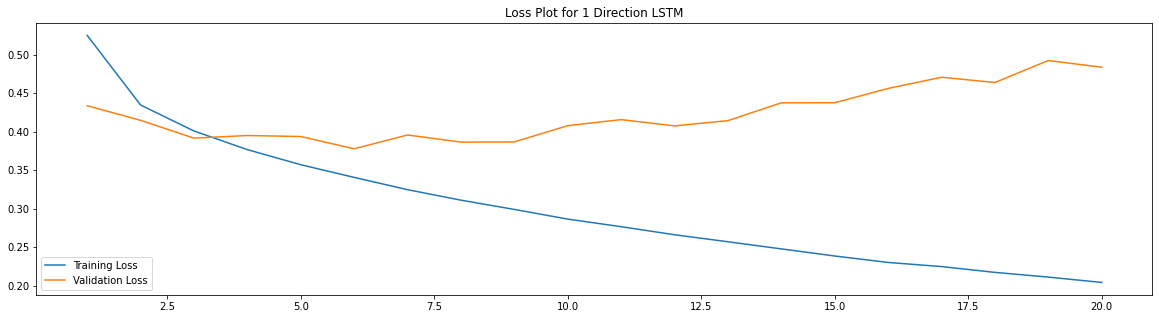

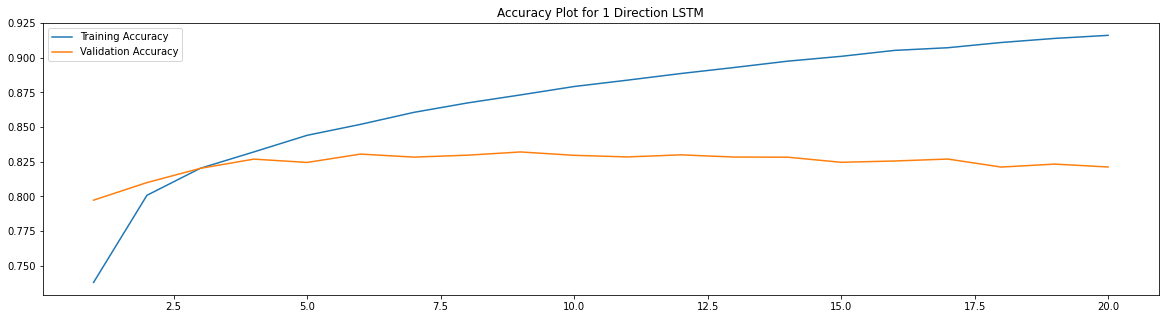

In [167]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_losses, label='Validation Loss')
plt.title('Loss Plot for 1 Direction LSTM')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_accs, label='Training Accuracy')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_accs, label='Validation Accuracy')
plt.title('Accuracy Plot for 1 Direction LSTM')
plt.legend()
plt.show()

#### Training the Model - BiDirectional

In [168]:
optimizer = optim.Adam(model_2D.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model_2D.to(device)
criterion = criterion.to(device)

In [169]:
NUM_EPOCHS = 20

best_valid_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_2D, train_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(model_2D, valid_iterator, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))



Epoch 1:
	 Total Time: 0m 36s
	 Train Loss 0.51 | Train Accuracy: 74.29%
	 Validation Loss 0.44 | Validation Accuracy: 79.88%
Epoch 2:
	 Total Time: 0m 36s
	 Train Loss 0.43 | Train Accuracy: 80.21%
	 Validation Loss 0.41 | Validation Accuracy: 81.22%
Epoch 3:
	 Total Time: 0m 36s
	 Train Loss 0.4 | Train Accuracy: 82.28%
	 Validation Loss 0.39 | Validation Accuracy: 82.09%
Epoch 4:
	 Total Time: 0m 35s
	 Train Loss 0.37 | Train Accuracy: 83.62%
	 Validation Loss 0.38 | Validation Accuracy: 82.67%
Epoch 5:
	 Total Time: 0m 35s
	 Train Loss 0.35 | Train Accuracy: 84.62%
	 Validation Loss 0.38 | Validation Accuracy: 82.94%
Epoch 6:
	 Total Time: 0m 35s
	 Train Loss 0.34 | Train Accuracy: 85.53%
	 Validation Loss 0.38 | Validation Accuracy: 83.1%
Epoch 7:
	 Total Time: 0m 35s
	 Train Loss 0.32 | Train Accuracy: 86.22%
	 Validation Loss 0.39 | Validation Accuracy: 83.27%
Epoch 8:
	 Total Time: 0m 35s
	 Train Loss 0.31 | Train Accuracy: 86.88%
	 Validation Loss 0.39 | Validation Accuracy: 8

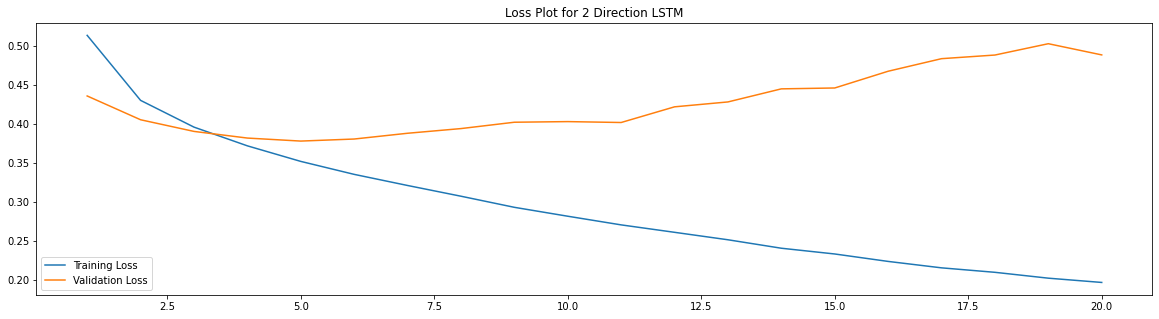

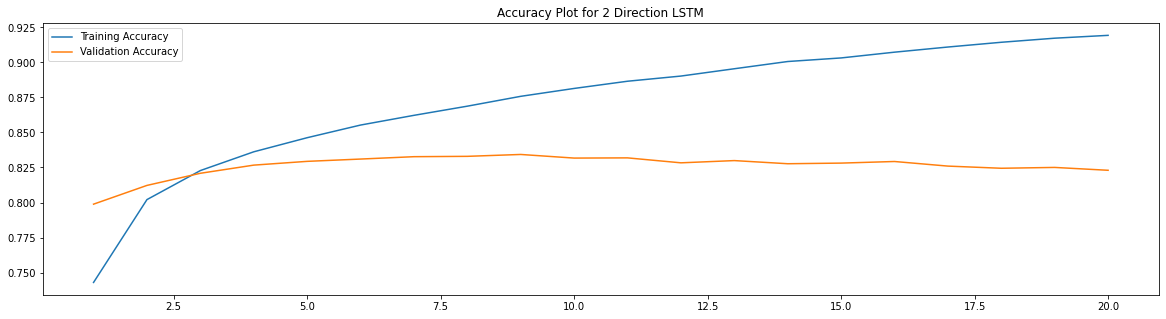

In [170]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_losses, label='Validation Loss')
plt.title('Loss Plot for 2 Direction LSTM')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_accs, label='Training Accuracy')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_accs, label='Validation Accuracy')
plt.title('Accuracy Plot for 2 Direction LSTM')
plt.legend()
plt.show()